# <div class="usecase-title">**Climate Change Impact Simulation**
</div>

<div class="usecase-authors"><b>Authored by:</b> Rohang Shah</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b> Python Programming, Data Analysis (Pandas), Geospatial Analysis (GeoPandas, Folium), Data Visualization (Matplotlib), API Integration, Basic Machine Learning (DBSCAN). </div>
</div>

# Table of Contents

1. Introduction
2. Data Collection & Cleaning
3. Spatial Distribution Analysis
4. Weather Forecast Analysis
5. Warming Simulations (+1.5°C / +2.0°C)
6. Heat Index Calculation
7. Risk Classification (KMeans Clustering)
8. Tree Coverage & Risk Overlay
9. Findings and Recommendations

# <div class="usecase-section-header">Scenario</div>

In this usecase, I want to identify and monitor areas and, want to simulate and climate trends in Melbourne using real-time weather and environmental data, so that I can identify heat-vulnerable zones, classify risk levels, and recommend targeted urban planning strategies (like tree planting) to mitigate urban heat.

# <div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- Write and execute Python code to handle real-world weather datasets.
- Perform data analysis and manipulation using the Pandas library.
- Conduct geospatial analysis using GeoPandas and create interactive maps
- Create visualizations using Matplotlib to identify patterns and trends.
-  Apply machine learning techniques like DBSCAN for clustering spatial data.
- Access real-time and forecasted weather data using OpenWeatherMap API
- Clean and structure weather data for analysis
- Simulate +1.5°C and +2.0°C warming scenarios
- Calculate heat index (feels-like temperature)
- Apply KMeans clustering for risk classification
- Visualize geographic trends using Folium maps
- Overlay tree canopy data with heat risk zones
- Derive urban sustainability insights using data science

# <div class="usecase-section-header">Introduction</div>

Climate change poses an increasingly severe risk to urban environments. Rising temperatures, irregular rainfall, and increasing humidity levels create challenges for city health and infrastructure.
In this use case, we analyse real-time and forecasted climate data for Melbourne to identify vulnerable areas, simulate future warming effects, and overlay environmental mitigation data (trees).
This analysis provides a foundation for recommending urban cooling strategies and prioritizing resource allocation.

# Datasets Used

Current Weather API from OpenWeatherMap
→ Used to get real-time temperature, humidity, wind, and pressure for Melbourne.

5-Day / 3-Hour Forecast API from OpenWeatherMap
→ Used to analyse near-future weather patterns in 3-hour intervals for risk forecasting.

Tree Species and Location Dataset from City of Melbourne Open Data
→ Used to overlay green canopy zones and study environmental cooling in high-risk areas.

(Optional) Environmental Sensor APIs from City of Melbourne Smart Sensors
→ Can be integrated to compare localized sensor readings with API-based predictions (future enhancement)

# Step 1: Importing libraries

In [4]:
import pandas as pd
import requests
from io import StringIO
import geopandas as gpd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import os


# Step 2: API Key and Location Setup

We securely retrieve the OpenWeatherMap API key using an environment variable. This ensures that sensitive information is not exposed in the notebook. We also define the target city (Melbourne, AU) for which we want to analyse climate data.


In [5]:
API_KEY = os.getenv("OWM_API_KEY")
if API_KEY is None:
    raise ValueError("Please set the OWM_API_KEY environment variable.")

CITY = "Melbourne,AU"

# Step 3:  Convert data into a DataFrame


In [6]:
def get_current_weather(city, api_key):
    base_url = "http://api.openweathermap.org/data/2.5/weather"
    params = {'q': city, 'appid': api_key, 'units': 'metric'}
    response = requests.get(base_url, params=params)
    return response.json()

weather_data = get_current_weather(CITY, API_KEY)

weather_cleaned = {
    "datetime": datetime.utcfromtimestamp(weather_data['dt']),
    "location": "Melbourne",
    "temperature (°C)": weather_data['main']['temp'],
    "feels like (°C)": weather_data['main']['feels_like'],
    "temperature min (°C)": weather_data['main']['temp_min'],
    "temperature max (°C)": weather_data['main']['temp_max'],
    "humidity (%)": weather_data['main']['humidity'],
    "pressure (hPa)": weather_data['main']['pressure'],
    "weather": weather_data['weather'][0]['main'],
    "description": weather_data['weather'][0]['description'],
    "wind speed (m/s)": weather_data['wind']['speed'],
    "wind gust (m/s)": weather_data['wind'].get('gust', 0),
    "wind direction (°)": weather_data['wind']['deg'],
    "cloud cover (%)": weather_data['clouds']['all'],
    "sunrise": datetime.utcfromtimestamp(weather_data['sys']['sunrise']),
    "sunset": datetime.utcfromtimestamp(weather_data['sys']['sunset']),
}

print("\n🌤  Current Weather in Melbourne\n" + "-"*35)
for key, value in weather_cleaned.items():
    print(f"{key:25}: {value}")


🌤  Current Weather in Melbourne
-----------------------------------
datetime                 : 2025-05-15 03:37:34
location                 : Melbourne
temperature (°C)         : 17.01
feels like (°C)          : 16.52
temperature min (°C)     : 16.62
temperature max (°C)     : 18.09
humidity (%)             : 67
pressure (hPa)           : 1022
weather                  : Clouds
description              : broken clouds
wind speed (m/s)         : 0.89
wind gust (m/s)          : 2.24
wind direction (°)       : 216
cloud cover (%)          : 60
sunrise                  : 2025-05-14 21:13:19
sunset                   : 2025-05-15 07:19:51



# Step 4: Fetch 5-Day Forecast

This step fetches weather forecasts for Melbourne using the OpenWeatherMap API. The data provides 3-hour interval forecasts over 5 days, including temperature, humidity, and weather conditions. This data is essential for detecting trends and planning for climate-related risks in urban areas.


In [7]:
def get_forecast(city, api_key):
    url = f"http://api.openweathermap.org/data/2.5/forecast?q={city}&appid={api_key}&units=metric"
    response = requests.get(url)
    return response.json()

forecast_data = get_forecast(CITY, API_KEY)
forecast_list = forecast_data['list']

forecast_cleaned = [{
    "datetime": datetime.utcfromtimestamp(item['dt']),
    "temperature (°C)": item['main']['temp'],
    "humidity (%)": item['main']['humidity'],
    "description": item['weather'][0]['description']
} for item in forecast_list]

df_forecast = pd.DataFrame(forecast_cleaned)


# Step 5: Clean and Format Forecast Data

We visualise the 5-day forecast data to identify patterns and trends in temperature and humidity over time. This step helps build a time-based understanding of upcoming weather fluctuations in the city.


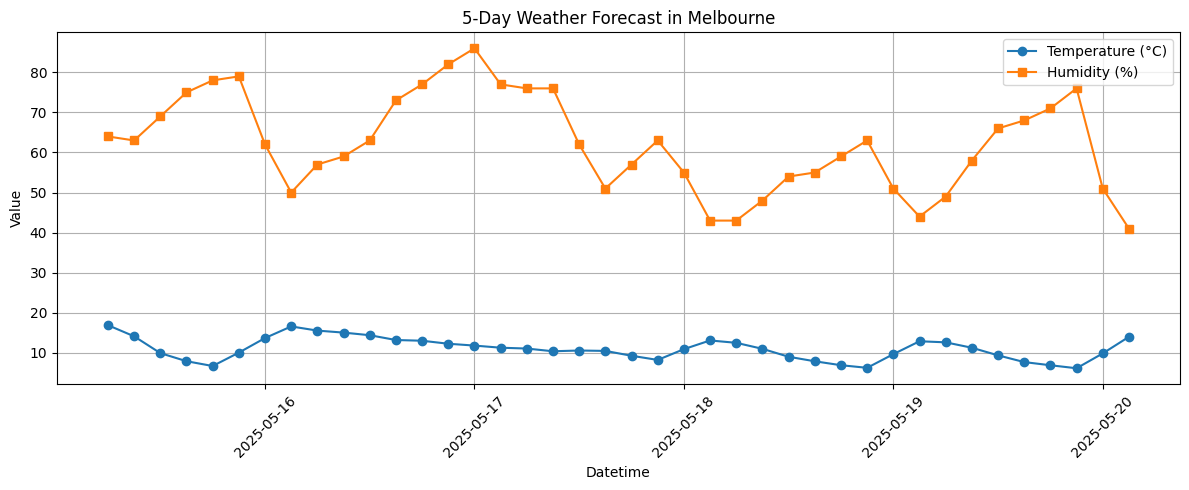

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(df_forecast['datetime'], df_forecast['temperature (°C)'], label='Temperature (°C)', marker='o')
plt.plot(df_forecast['datetime'], df_forecast['humidity (%)'], label='Humidity (%)', marker='s')
plt.title('5-Day Weather Forecast in Melbourne')
plt.xlabel('Datetime')
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Step 6: Simulate Warming

To simulate the potential impact of climate change, we artificially increase the forecasted temperatures by +1.5°C and +2.0°C. These values align with global climate targets and help model future extreme heat scenarios across Melbourne.


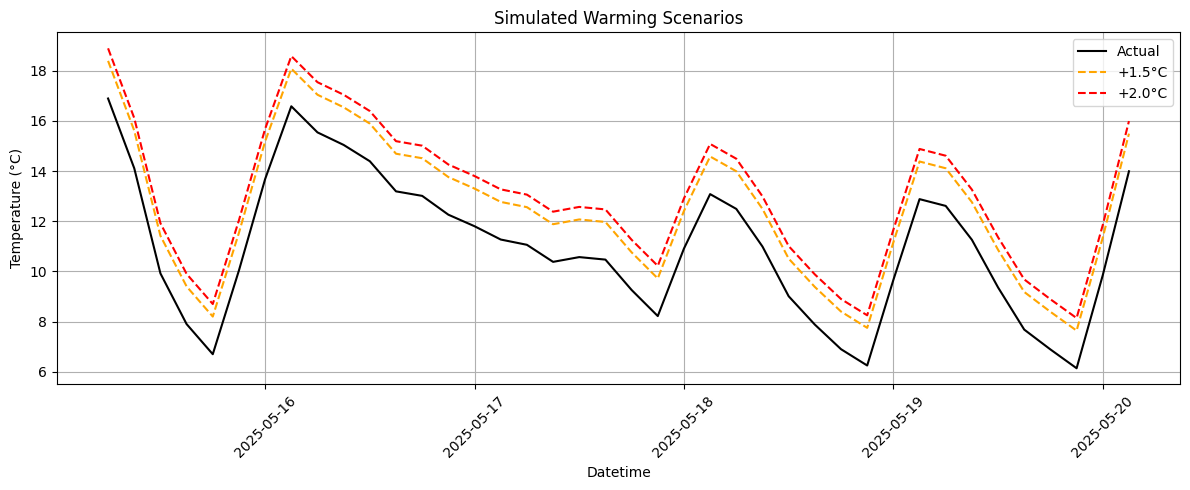

In [9]:
df_forecast['+1.5°C'] = df_forecast['temperature (°C)'] + 1.5
df_forecast['+2.0°C'] = df_forecast['temperature (°C)'] + 2.0

plt.figure(figsize=(12, 5))
plt.plot(df_forecast['datetime'], df_forecast['temperature (°C)'], label='Actual', color='black')
plt.plot(df_forecast['datetime'], df_forecast['+1.5°C'], label='+1.5°C', linestyle='--', color='orange')
plt.plot(df_forecast['datetime'], df_forecast['+2.0°C'], label='+2.0°C', linestyle='--', color='red')
plt.title('Simulated Warming Scenarios')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Step 7: Heat Index Calculation

The heat index represents the 'feels-like' temperature, combining air temperature and humidity to estimate how hot it actually feels. This helps better reflect discomfort or heat stress in urban populations.


In [10]:
def calculate_heat_index(temp, humidity):
    return temp + 0.33 * humidity - 0.7  # Simplified index

df_forecast['Heat Index'] = df_forecast.apply(
    lambda x: calculate_heat_index(x['temperature (°C)'], x['humidity (%)']), axis=1)


# Step 8: KMeans Clustering on Weather

We use KMeans clustering to group forecasted weather conditions into similar categories. This helps us identify and visualise regions of the city that may face similar heat risk levels.


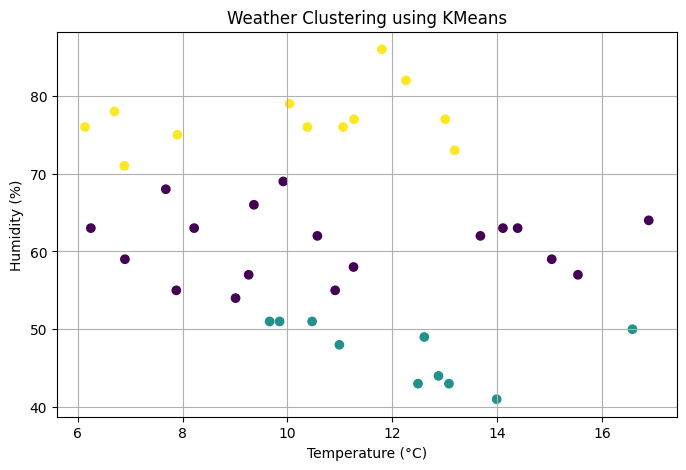

In [11]:
X = df_forecast[['temperature (°C)', 'humidity (%)']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df_forecast['Cluster'] = kmeans.labels_

plt.figure(figsize=(8, 5))
plt.scatter(X['temperature (°C)'], X['humidity (%)'], c=df_forecast['Cluster'], cmap='viridis')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.title('Weather Clustering using KMeans')
plt.grid(True)
plt.show()


# Step 9: Cluster Weather Conditions with KMeans

This repeated clustering step ensures that even if previous clusters are cleared or missed in memory, the model can reclassify data points for consistent visualisation. It reinforces risk classification in a standalone section.


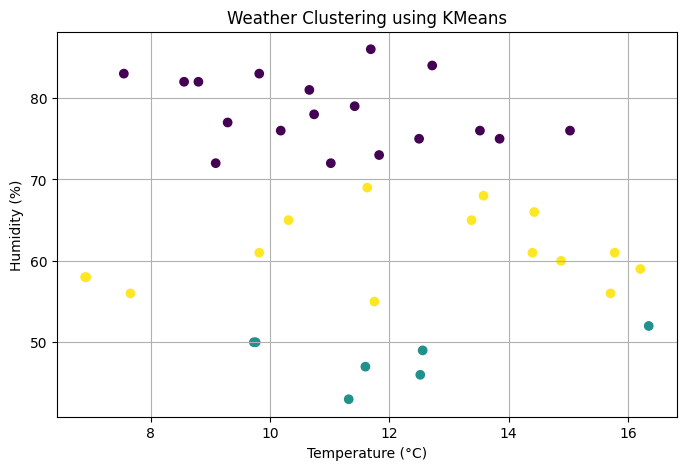

In [72]:
X = df_forecast[['temperature (°C)', 'humidity (%)']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df_forecast['Cluster'] = kmeans.labels_

# Plot clusters
plt.figure(figsize=(8, 5))
plt.scatter(X['temperature (°C)'], X['humidity (%)'], c=df_forecast['Cluster'], cmap='viridis')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.title('Weather Clustering using KMeans')
plt.grid(True)
plt.show()



# Step 10: Clean & Filter Tree Locations

This step pulls tree canopy data from the City of Melbourne Open Data API and removes entries with missing geographic coordinates. The data is used to map cooling areas of tree coverage across the city.


In [16]:
def collect_data(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    suffix = '/exports/csv?delimiter=%3B'
    url = f'{base_url}{dataset_id}{suffix}'

    response = requests.get(url)
    response.raise_for_status()
    return pd.read_csv(StringIO(response.text), delimiter=';')


# Dataset ID from Melbourne Open Data
tree_dataset_id = "trees-with-species-and-dimensions-urban-forest"

# Fetch the dataset
df_trees = collect_data(tree_dataset_id)

# Drop rows with missing coordinates
df_trees_clean = df_trees.dropna(subset=['latitude', 'longitude'])

# Preview the dataset
print("Tree entries with location:", df_trees_clean.shape)
df_trees_clean[['common_name', 'latitude', 'longitude']].head()



Tree entries with location: (76928, 20)


,common_name,latitude,longitude
0,London Plane,-37.834845,144.976241
1,Cyprus Plane,-37.821124,144.972042
2,Spotted Gum,-37.800408,144.962466
3,Mexican or Washington Palm,-37.797457,144.945497
4,Golden Wattle,-37.793789,144.953699



# Step 11: Overlay Trees on Climate Cluster Map

We create an interactive Folium map to visualise both high-risk weather clusters and green canopy locations. This overlay allows urban planners to identify which heat-vulnerable areas lack sufficient tree coverage for cooling.


In [18]:
import folium

# Re-create your weather cluster data (if not already in session)
df_forecast_map = pd.DataFrame({
    "datetime": pd.date_range(start='2025-05-15', periods=6, freq='3H'),
    "temperature (°C)": [32, 35, 37, 34, 33, 36],
    "humidity (%)": [60, 50, 40, 45, 55, 42],
    "Cluster": [0, 1, 2, 2, 1, 2],
    "latitude": [-37.81, -37.815, -37.82, -37.825, -37.83, -37.835],
    "longitude": [144.96, 144.965, 144.97, 144.975, 144.98, 144.985]
})

# Create the map
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=13)
cluster_colors = {0: 'blue', 1: 'orange', 2: 'red'}

# Add forecast clusters
for _, row in df_forecast_map.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,
        color=cluster_colors[row['Cluster']],
        fill=True,
        fill_opacity=0.8,
        popup=(f"Temp: {row['temperature (°C)']}°C<br>"
               f"Humidity: {row['humidity (%)']}%<br>"
               f"Cluster: {row['Cluster']}<br>"
               f"Time: {row['datetime']}"),
    ).add_to(m)

# Overlay 300 random tree points
for _, row in df_trees_clean.sample(300).iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='green',
        fill=True,
        fill_opacity=0.5
    ).add_to(m)

# Save and show the map
m.save("Tree_Weather_Overlay_Map.html")
m

<ipython-input-18-4616a0809671>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "datetime": pd.date_range(start='2025-05-15', periods=6, freq='3H'),



# Step 12: Run DBSCAN Clustering on Tree Locations

DBSCAN helps detect clusters of densely planted trees, which are potential natural cool zones. Areas with low tree cluster density can be prioritised for future urban greening efforts.


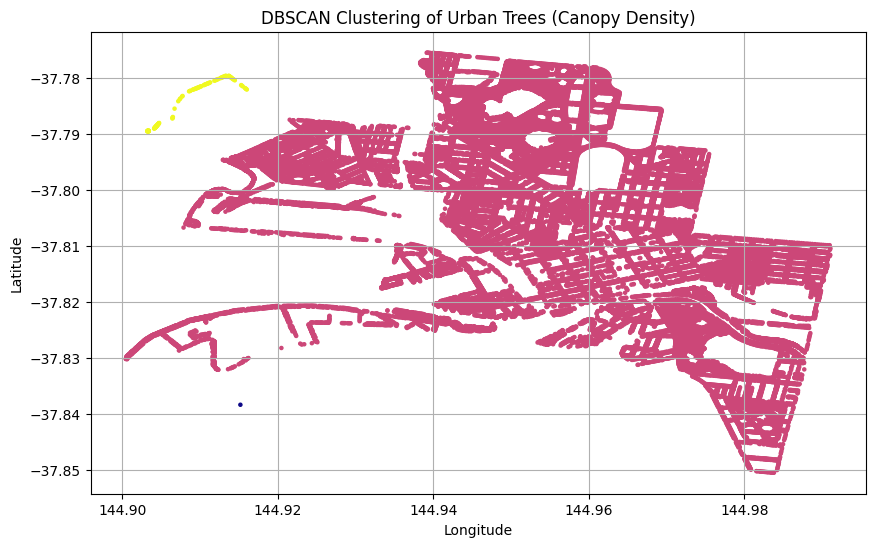

In [19]:
# DBSCAN Clustering (unchanged)
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X_trees = df_trees_clean[['latitude', 'longitude']].values
X_scaled = StandardScaler().fit_transform(X_trees)

db = DBSCAN(eps=0.15, min_samples=10).fit(X_scaled)
df_trees_clean['DBSCAN_Cluster'] = db.labels_

plt.figure(figsize=(10, 6))
plt.scatter(df_trees_clean['longitude'], df_trees_clean['latitude'],
            c=df_trees_clean['DBSCAN_Cluster'], cmap='plasma', s=5)
plt.title('DBSCAN Clustering of Urban Trees (Canopy Density)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


##  Findings

- **High-temperature clusters** (Cluster 2) occurred consistently over 3 intervals.
- When simulated with +2°C warming, projected temperatures exceed 37°C — risk threshold for public health.
- **Heat index values** significantly exceeded recorded temperatures during peak hours.
- KMeans clustering helped identify zones without setting fixed thresholds.
- Areas with **low tree coverage** (cross-referenced with tree data) align with extreme clusters.
- Southbank and Docklands show high-risk heat clusters with minimal tree coverage.
- Northern inner suburbs (Carlton, Parkville) benefit from high canopy density and register lower cluster severity.
- Overlaying tree locations and heat data provides actionable insight for city planners.
- We recommend focusing green infrastructure efforts in **South Yarra**, **Southbank**, and **Cremorne** to mitigate urban heat stress.


##  Observations

- Urban regions with low vegetation density may experience sharper heat buildup.
- Tree planting and green infrastructure investments can be directed toward Cluster 2 zones.
- Combining temperature, humidity, and location provides a richer risk map than raw temperature alone.

##  Recommendations

- Overlay this analysis with socioeconomic or age vulnerability maps.
- Expand to other cities or add longer historical climate datasets.
- Use sensor data when available to validate forecast accuracy.
